In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from ipywidgets import interact

In [12]:
from IPython.display import HTML

HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
<ul>
<li>The code is in Python. Matlab does not work with the interactive elements used in this notebook.
<li>The current version of ipywidgets shows only static images online.  Interactivity can only be viewed by downloading and running in a Jupyter Notebook server.  The next version of ipywidgets will permit online viewing of interactivity.
</ul>
''')

# Trust Region

In [13]:
ymin = -4.0
ymax = 8.0
xmin = -4.0
xmax = 6.0

x0 = np.array([2.0, 1.0])

In [14]:
def rosenbrock(xvec):
    x = xvec[0]
    y = xvec[1]

    f = (1.0 - x)**2 + 100.0*(y - x**2)**2

    g = np.zeros(2)
    g[0] = -2*(1 - x) + 200*(y - x**2)*-2*x
    g[1] = 200*(y - x**2)

    H = np.zeros((2, 2))
    H[0, 0] = 2.0 + 1200.0*x**2 - 400.0*y
    H[0, 1] = -400.0*x
    H[1, 0] = -400.0*x
    H[1, 1] = 200.0

    return f, g, H


In [15]:
f, g, H = rosenbrock(x0)

def quad(x):

    s = x - x0
    fnew = f + np.dot(g, s) + 0.5*np.dot(s, np.dot(H, s))
    gnew = g + np.dot(H, s)

    return fnew, gnew

In [16]:
n = 200
x = np.linspace(xmin, xmax, n)
y = np.linspace(ymin, ymax, n)
[X, Y] = np.meshgrid(x, y, indexing='ij')
Z = np.zeros((n, n))
Zquad = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        xvec = np.array([X[i, j], Y[i, j]])
        Z[i, j], _, _ = rosenbrock(xvec)
        Zquad[i, j], _ = quad(xvec)


The plot below show the Rosenbrock function in faded black and a blue quadratic approximation to the function about the blue dot.

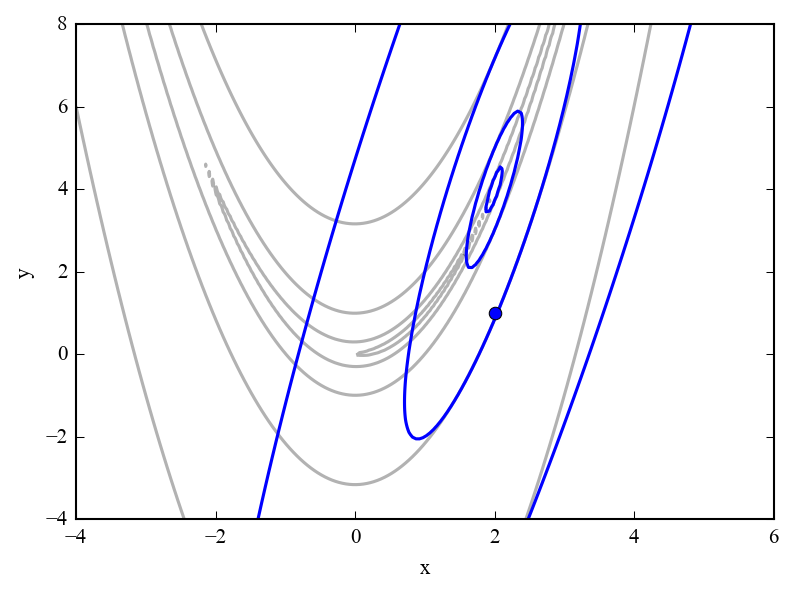

In [17]:
 # plot rosenbrock
plt.figure()

levels = [1., 10.0, 100.0, 1000.0, 1e4]
plt.contour(X, Y, Z, levels, colors='k', alpha=0.3)
plt.xlabel('x')
plt.ylabel('y')

# plot quadratic model
levels = [1., 10.0, 100.0, 1000.0, 1e4]
plt.contour(X, Y, Zquad, levels, colors='b')
plt.plot(x0[0], x0[1], 'bo')

plt.show()

We now add a trust region radius as a red dashed line, and show the optimal point (from the blue model) within that radius as a red dot.  An actual trust region algorithm doesn't necessary find the exact optimum (it uses a more efficient, but approximate method to avoid actually solving an internal optimization problem), but for our purposes we will assume that it does.  You can change the trust region radius with the slider below.  Note that at large radii, the solution is unaffected by the radius and sits at the minimum point of the quadratic. As the trust region radius decreases, the constrained optimum moves and the step direction changes.

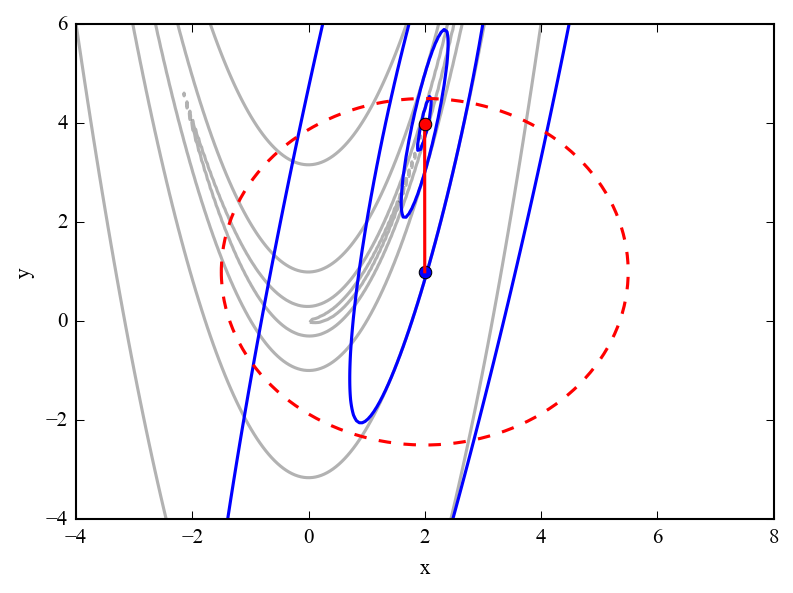

In [18]:
@interact(R=(0.0,5.0,0.1))
def radius(R=3.5):
    
    # redefine constraint
    def con(x):
        return [R - np.linalg.norm(x - x0)]
    
    # solve optimization problem
    constraints = {'type': 'ineq', 'fun': con}
#     options={'disp': True, 'iprint': 2, 'maxiter': 1000}

    res = minimize(quad, x0, method='SLSQP', jac=True, constraints=constraints)  #, options=options)
    
    
    # plot rosenbrock
    plt.figure()

    levels = [1., 10.0, 100.0, 1000.0, 1e4]
    plt.contour(X, Y, Z, levels, colors='k', alpha=0.3)
    plt.xlabel('x')
    plt.ylabel('y')

    # plot quadratic model
    levels = [1., 10.0, 100.0, 1000.0, 1e4]
    plt.contour(X, Y, Zquad, levels, colors='b')
    plt.plot(x0[0], x0[1], 'bo')

    # plot circle boundary
    theta = np.linspace(-np.pi, np.pi, 300)
    xt = x0[0] + R*np.cos(theta)
    yt = x0[1] + R*np.sin(theta)
    plt.plot(xt, yt, 'r--')

    # plot optimal point within boundary (using model)
    xopt = res.x
    plt.plot([x0[0], xopt[0]], [x0[1], xopt[1]], 'r')
    plt.plot(xopt[0], xopt[1], 'ro')


#     plt.axis('equal')
    plt.xlim([-4, 8])
    plt.ylim([-4, 6])

    plt.show()